<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/predict_sticker_sales/sticker_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install fastai
!pip install fastai.structured

In [4]:
%%capture
import pandas as pd
from fastai.tabular.all import *
from fastai.data.transforms import IndexSplitter

# Predicting Sticker Sales

## Introduction

As I continue my machine learning (ML) journey, it seemed like I had accumulated sufficient knowledge to participate in a Kaggle competition. As such, I decided to produce a model to submit to this competition: [Forecasting Sticker Sales](https://www.kaggle.com/competitions/playground-series-s5e1/overview).

Since I've spent a lot of time working through the examples provided in the wonderful fastai course, I decided it was time to produce some of my own work to demonstrate my knowledge acquisition thus far. By using the course material on different data and using my own research, I have a chance to check my knowledge and perform some creative problem-solving to make a solid submission.

In this Kaggle competition, the goal is to predict the number of sticker sales based on training data which includes past sticker sales as well as:
- `date`
- `country`
- `store`
- `product`

This competition is aimed to be approachable, for people to practice their ML skills. But, it still provides real-world data and hidden test sets. I'm excited to demonstrate my ML knowledge through this challenge!

So far, I've learnt **deep learning** as part of my machine learning journey, so this is the approach I will take! However, it would also be worth attempting an **ensemble of decision trees** based approach, given we are working with **structured data** (i.e., tabular data).

## Data Extraction

I've manually uploaded `train.csv` and `test.csv` to the folder for this notebook to use for training the model. We will use Pandas, which is great for handling csv files and inspect the contents of the dataframe.

In [5]:
df = pd.read_csv('train.csv')
df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [6]:
df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,8871


The first thing that I've noticed is that the training dataset contains a number of `NaN` values. However, unusually, these values are only in the dependent variable.

While this is a situation I have not yet come across, I can immediately identify that unlike `NaN` values in our features, we can not fill these with the *mean* or the *mode*. While this technique is suitable for features, as it allows the model to use the remaining data in the row, by filling our dependent variable with meaningless values, we will essentially be training it on incorrect values. This will not help our model.

At this stage, I'm not sure how I can use this data to improve my model, so I will use only the labelled data for now. We have over 230,000 labelled pieces of data so we will not drastically impact the model by removing an odd 9,000 rows (representing only ~4% of the dataset).

In [7]:
df.dropna(axis=0, inplace=True)
df

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [8]:
df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,0


## Feature Engineering

Perfect! The `NaN` values are removed. Now let's take a deeper dive into our data using the Pandas `describe()` method.

In [9]:
df.describe(include='all')

,id,date,country,store,product,num_sold
count,221259.000000,221259,221259,221259,221259,221259.000000
unique,NaN,2557,6,3,5,NaN
top,NaN,2010-01-24,Finland,Premium Sticker Mart,Kaggle,NaN
freq,NaN,88,38355,75684,46026,NaN
mean,115398.848472,NaN,NaN,NaN,NaN,752.527382
std,66315.365084,NaN,NaN,NaN,NaN,690.165445
min,1.000000,NaN,NaN,NaN,NaN,5.000000
25%,58160.500000,NaN,NaN,NaN,NaN,219.000000
50%,115552.000000,NaN,NaN,NaN,NaN,605.000000
75%,172688.500000,NaN,NaN,NaN,NaN,1114.000000


At the moment, the `date` field cannot be fed into the model. Furthermore, in its current format, it only provides insight into whether one sale occured before or after another sale. But dates can provide **a lot more detail** than this and fastai provides a suite of methods to deal with `datetime` features.

We will use the `add_datepart()` function I found online that is provided by fastai. This function adds several useful features to the dataset including whether it is the start or end of the year or quarter, and more.

It is important to perform **feature engineering** on the date feature as the date that the sales originate is likely to have the biggest impact on sales. For example, people may be more likely to make sticker purchases towards the end of the year when Christmas is. This means we're letting the model know more than just whether a date is more or less recent than another!

In [10]:
add_datepart(df, 'date')
df

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


,id,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
5,5,Canada,Stickers for Less,Holographic Goose,300.0,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230126,230126,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230127,230127,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230128,230128,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09


We've easily generated several useful features from the date column to feed into our model!

Let's have a look at the variables now and see how many distinct values they have. This will help in determining what is a **continuous** vs a **categorical** variable.

In [11]:
df.nunique()

,0
id,221259
country,6
store,3
product,5
num_sold,4037
Year,7
Month,12
Week,53
Day,31
Dayofweek,7


It seems like our only continuous variables will be `Dayofyear` and `Elapsed`. It is possible that some of our other variables like `Week` or `Day` could be passed as continuous variables, but since they have a smaller number of distinct values we will attempt to use them as categorical variables.

In my first attempt, I performed no further feature engineering at this point.

However, the model was scoring extremely poorly, with a Mean Absolute Percentage Error (MAPE - the metric defined by the Kaggle competition) of approximately `1.0`. After doing some researching online and relying on my own intuition, I determined that the extremely large (and sometimes extremely low) values of `num_score` were likely impacting the model. A value like MAPE will be very sensitive to large discrepancies and therefore outliers.



In [12]:
df['num_sold'].min(), df['num_sold'].max()

(5.0, 5939.0)

Having a look here, we can see that in one row of the dataframe only 5 stickers were sold! But our maximum values is almost 6000 stickers. This big difference was causing significant failings in our model and metric.

As such, I performed the following **log transformation** to the `num_sold` column. The independent variables (or features) will be automatically normalised by the fastai `dataloaders` object so these do not require log transformations.

In [13]:
df['num_sold'] = np.log1p(df['num_sold'])

By taking the log of `num_sold` now and using the model to predict `log(num_sold)`, we can easily transform out predictions back into `num_sold` using the exponential function.

This simple feature engineering improved our  MAPE from `1.0` to `0.1`!

At this stage our tabular data is ready, we will just drop the `id` column since it is not relevant to the model. It is a unique value from `0` to `n` and in the same order as `date`.

In [14]:
df.drop('id', axis=1, inplace=True)

In [15]:
df

,country,store,product,num_sold,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
1,Canada,Discount Stickers,Kaggle,6.881411,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
2,Canada,Discount Stickers,Kaggle Tiers,6.810142,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
3,Canada,Discount Stickers,Kerneler,6.049733,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
4,Canada,Discount Stickers,Kerneler Dark Mode,6.198479,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
5,Canada,Stickers for Less,Holographic Goose,5.707110,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,Singapore,Premium Sticker Mart,Holographic Goose,6.146329,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230126,Singapore,Premium Sticker Mart,Kaggle,7.975221,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230127,Singapore,Premium Sticker Mart,Kaggle Tiers,7.740664,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09
230128,Singapore,Premium Sticker Mart,Kerneler,7.125283,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09


## Validation Set

An important learning that I've made so far is that choosing a suitable and meaningful validation set is extremely important when training a model. While it is tempting to use a random split of the data, in this situation, it is likely unideal. Since we will be using the model to predict **future** sales, it makes sense to the same with the validation set.

As such, I intend on trimming the later sales in the dataset to use as the validation set and the sales that were made before then can be used to fit the parameters.

In [16]:
df.groupby("Year").count()

,country,store,product,num_sold,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Year,,,,,,,,,,,,,,,,
2010,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141,31141
2011,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445,31445
2012,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719,31719
2013,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721,31721
2014,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823,31823
2015,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643,31643
2016,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767,31767


Having a look at the number of rows for each year, it makes sense to split the model using:

```
sold in 2016 vs ~sold in 2016
```
This means of our 221,259 rows of data, our validation set will represent ~14% of our dataset at 31,767 values. This is a reasonable split, especially given the reasonably large amount of data we have access to.


In [17]:
df = df.reset_index(drop=True)  # Ensure the index is sequential

val_i = df[df['Year'] == 2016].index # indices of validation data

splitter = IndexSplitter(val_i)
splits = splitter(df)

len(splits[0]), len(splits[1])

(189492, 31767)

Seems like a great split!

Let's make our `dataloaders` object now! We don't need to specify `y_block` as fastai infers this automatically. However, we will need to specify our continuous and categorical variables (which we have already discussed above). We will also need to specify our dependent variable.

In [18]:
cont_names = ['Dayofyear', 'Elapsed']
cat_names = [i for i in df.columns if i not in cont_names + ['num_sold']]
cont_names, cat_names

(['Dayofyear', 'Elapsed'],
 ['country',
  'store',
  'product',
  'Year',
  'Month',
  'Week',
  'Day',
  'Dayofweek',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start'])

In [19]:
dls = TabularPandas(df,
                    splits=splits,
                    procs=[Categorify,Normalize],
                    cont_names=cont_names,
                    cat_names=cat_names,
                    y_names='num_sold'
).dataloaders(path='.')

Upon analysing the specificities of the Kaggle competition, it is noted that the metric with with the models are evaluated is the **Mean Absolute Percentage Error** (MAPE).

Since this is not provided by default by fastai, I have created my own function to deal with this.

In [20]:
from fastai.metrics import mae

# Define MAPE as a simple function
def mape(preds, targs):
    epsilon = 1e-7  # To avoid division by zero
    return ((targs - preds).abs() / (targs.abs() + epsilon)).mean()

## Fit the Model

Now that we have both:
- a metric, and,
- a dataloaders object with training and validation sets,

we can create a `learner` using `tabular_learner` provided by fastai. This will choose a suitable architecture depending on our data.

In [21]:
learn = tabular_learner(dls, metrics=[mape])

Now that we have a `learner` let's use some of fastai's advanced features to choose the best learning rate.

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(slide=0.00010964782268274575, valley=0.009120108559727669)

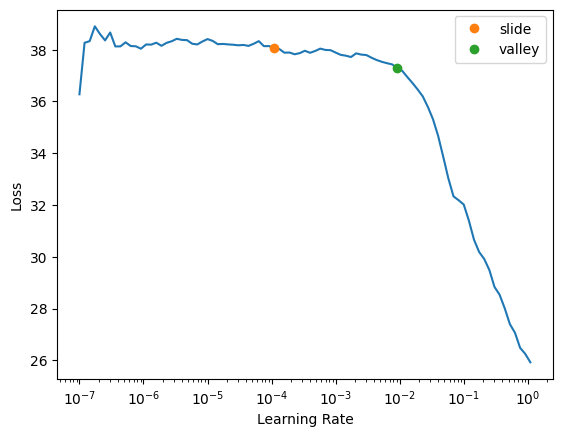

In [22]:
learn.lr_find(suggest_funcs=(slide, valley))

I'm choosing a **learning rate** around the value of *valley*. This is generally a conservative estimate of a suitable learning rate, which is supposed to prevent **overfitting**.

In [23]:
learn.fit(5, lr=0.01)

epoch,train_loss,valid_loss,mape,time
0,0.075992,0.023938,0.023933,00:36
1,0.055141,0.014570,0.017490,00:32
2,0.065536,0.020186,0.022803,00:33
3,0.058110,0.069707,0.037322,00:34
4,0.063058,0.022807,0.025617,00:33


Our `learner` model is performing well. We are achieving a **MAPE** of around 0.025 which is excellent and the model is training in around 30 seconds per epoch.

However, we can definitely see overfitting occuring with this model, as our loss function begins getting worse after epoch 1. This is something we will address with **weight decay** in the next model.

## Pseudo-Labelling

While the model is already performing very well, why not aim even higher?!

When considering ways of improving my model, it is clear that I could experiment with a range of different **hyperparameters** and **architectures**. However, I think the single biggest improvement I could make straight away is to use the remaining data that I removed from the dataframe at the beginning! While this data was unlabelled, it still contained useful information to fit the model and using **semi-supervised learning** we can make the most of **all** the data that was provided.

To perform **pseudo-labelling** we will use our trained model to predict `num_sold` for the rows where this data is missing. These preditions will be treated as pseduo-labels and combined back into the training dataset.

Then, we will retrain the model on the combined dataset.

First, we will extract the unlabelled data from the `train.csv` file and perform the same transformation on the `date` column.

In [24]:
unlabelled = pd.read_csv('train.csv')
unlabelled = unlabelled[unlabelled['num_sold'].isnull()]
unlabelled.drop(['num_sold','id'], axis=1, inplace=True)
add_datepart(unlabelled, 'date')
unlabelled

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


,country,store,product,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Canada,Discount Stickers,Holographic Goose,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
45,Kenya,Discount Stickers,Holographic Goose,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09
90,Canada,Discount Stickers,Holographic Goose,2010,1,53,2,5,2,False,False,False,False,False,False,1.262390e+09
135,Kenya,Discount Stickers,Holographic Goose,2010,1,53,2,5,2,False,False,False,False,False,False,1.262390e+09
180,Canada,Discount Stickers,Holographic Goose,2010,1,53,3,6,3,False,False,False,False,False,False,1.262477e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229905,Kenya,Discount Stickers,Holographic Goose,2016,12,52,29,3,364,False,False,False,False,False,False,1.482970e+09
229950,Canada,Discount Stickers,Holographic Goose,2016,12,52,30,4,365,False,False,False,False,False,False,1.483056e+09
229995,Kenya,Discount Stickers,Holographic Goose,2016,12,52,30,4,365,False,False,False,False,False,False,1.483056e+09
230040,Canada,Discount Stickers,Holographic Goose,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09


Now we will make predictions using this data.

In [25]:
nolabel_dl = learn.dls.test_dl(unlabelled)

preds,_ = learn.get_preds(dl=nolabel_dl)
preds

tensor([[5.0238],
        [1.7283],
        [5.0338],
        ...,
        [1.8684],
        [5.0092],
        [1.9257]])

In the next step, we are going to sort through our pseudo-labelled data and only choose the values with the highest **confidence**. We will select a **threshold** value of `0.7` and any prediction which the model makes which is less confident then this will not be used in training the new model.

> The "confidence" measures how close the prediction is to the baseline, which is the mean value of the `num_sold` column. The closer the prediction is to the baseline, the higher the confidence.

In [26]:
baseline_value = df['num_sold'].mean()
confidence = 1 - (abs(preds.squeeze() - baseline_value) / baseline_value)
unlabelled['num_sold'] = preds.squeeze().numpy() # removes the dimensions of size 1 from the tensor
unlabelled['confidence'] = confidence.numpy() # create new confidence column

We can see below that our `unlabelled` dataframe contains a column specifying the confidence of the model's prediction.

In [27]:
unlabelled

,country,store,product,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,num_sold,confidence
0,Canada,Discount Stickers,Holographic Goose,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09,5.023825,0.846052
45,Kenya,Discount Stickers,Holographic Goose,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09,1.728254,0.291052
90,Canada,Discount Stickers,Holographic Goose,2010,1,53,2,5,2,False,False,False,False,False,False,1.262390e+09,5.033811,0.847734
135,Kenya,Discount Stickers,Holographic Goose,2010,1,53,2,5,2,False,False,False,False,False,False,1.262390e+09,1.712924,0.288470
180,Canada,Discount Stickers,Holographic Goose,2010,1,53,3,6,3,False,False,False,False,False,False,1.262477e+09,5.105116,0.859743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229905,Kenya,Discount Stickers,Holographic Goose,2016,12,52,29,3,364,False,False,False,False,False,False,1.482970e+09,1.785732,0.300732
229950,Canada,Discount Stickers,Holographic Goose,2016,12,52,30,4,365,False,False,False,False,False,False,1.483056e+09,4.981189,0.838872
229995,Kenya,Discount Stickers,Holographic Goose,2016,12,52,30,4,365,False,False,False,False,False,False,1.483056e+09,1.868404,0.314654
230040,Canada,Discount Stickers,Holographic Goose,2016,12,52,31,5,366,True,False,True,False,True,False,1.483142e+09,5.009183,0.843587


Now we can sort through our dataframe, removing values that are below the predefined threshold.

In [28]:
threshold = 0.7
high_conf_df = unlabelled[unlabelled['confidence'] >= threshold]
high_conf_df

,country,store,product,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,num_sold,confidence
0,Canada,Discount Stickers,Holographic Goose,2010,1,53,1,4,1,False,True,False,True,False,True,1.262304e+09,5.023825,0.846052
90,Canada,Discount Stickers,Holographic Goose,2010,1,53,2,5,2,False,False,False,False,False,False,1.262390e+09,5.033811,0.847734
180,Canada,Discount Stickers,Holographic Goose,2010,1,53,3,6,3,False,False,False,False,False,False,1.262477e+09,5.105116,0.859743
270,Canada,Discount Stickers,Holographic Goose,2010,1,1,4,0,4,False,False,False,False,False,False,1.262563e+09,4.724149,0.795585
360,Canada,Discount Stickers,Holographic Goose,2010,1,1,5,1,5,False,False,False,False,False,False,1.262650e+09,4.731187,0.796770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229680,Canada,Discount Stickers,Holographic Goose,2016,12,52,27,1,362,False,False,False,False,False,False,1.482797e+09,4.780190,0.805023
229770,Canada,Discount Stickers,Holographic Goose,2016,12,52,28,2,363,False,False,False,False,False,False,1.482883e+09,4.871807,0.820451
229860,Canada,Discount Stickers,Holographic Goose,2016,12,52,29,3,364,False,False,False,False,False,False,1.482970e+09,4.876260,0.821201
229950,Canada,Discount Stickers,Holographic Goose,2016,12,52,30,4,365,False,False,False,False,False,False,1.483056e+09,4.981189,0.838872


This data is ready to fed back into the model to as **pseudo-labelled** data. We will combine all our data into a single dataframe and make the same validation split ready to update our dataloaders object with.

In [29]:
combined = pd.concat([df, high_conf_df])
combined.drop("confidence", axis=1, inplace=True)
combined = combined.reset_index(drop=True)
val_i = combined[combined['Year'] == 2016].index
splits = IndexSplitter(val_i)(combined)
splits

((#192959) [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19...],
 (#32546) [189492,189493,189494,189495,189496,189497,189498,189499,189500,189501,189502,189503,189504,189505,189506,189507,189508,189509,189510,189511...])

Now we can create our `dataloaders` object with all of our data (labelled and pseudo-labelled). We will update the `dls` in our `learn` model.

In [ ]:
dls_combined = TabularPandas(
    combined,
    splits=splits,
    procs=[Categorify, Normalize],
    cont_names=cont_names,
    cat_names=cat_names,
    y_names='num_sold'
).dataloaders(path='.')

learn = tabular_learner(dls_combined, metrics=[mape])

Since our last model experienced overfitting, I am taking extra precautions to avoid overfitting, reducing the **learning rate** to 0.001.

In [49]:
learn.fit(5, 0.001, wd=0.01)

epoch,train_loss,valid_loss,mape,time
0,0.050227,0.011963,0.017757,00:33
1,0.041179,0.010563,0.016394,00:33
2,0.051566,0.008278,0.013107,00:32
3,0.054810,0.008799,0.013769,00:33
4,0.046773,0.009779,0.014737,00:33


By using pseudo-labelled data, we have improved our MAPE from 0.025 to 0.014 and our learning rate has a much more consistent decline.

However, we've also made use of an extra hyperparameter called **weight decay** or **L2 regularization**. This hyperparameter is discussed further in my [collaborative filtering notebook](https://github.com/frank-895/machine_learning_journey/tree/main/collaborative_filtering) but essentially:
- a higher weight decay reduces overfitting but may make the model struggle to capture meaningful patterns.
- a lower weight decay could cause the model to overfit, but it will be better at capturing patterns in the data.

FastAI generally computes a suitable weight decay for us, but with tabular data it can struggle to understand our data and make a good prediction. As such, I experimented with a few different weight decays prior to find a good one.

Let's make our predictions and submit to the Kaggle competition.

## Making Predictions

First, we need to extract our **test data** and perform the same preprocessing. Then we can create a dataloaders object for the test data.

In [50]:
%%capture
test_df = pd.read_csv('test.csv')
add_datepart(test_df, 'date')
test_dl = learn.dls.test_dl(test_df)

Finally, we can generate predictions using our `learn` model. We mustn't forget that the model is outputting the predictions as a log, as we took a **log transformation** of the labels in the training dataset. Before submitting our predictions, we must take the exponent of our outputs.

In [51]:
preds = learn.get_preds(dl=test_dl)
test_df['num_sold'] = preds[0].numpy()
test_df['num_sold'] = np.expm1(test_df['num_sold'])

In [52]:
sub_df = test_df[['id','num_sold']]
sub_df.to_csv('submission.csv', index=False)

## Conclusion

After making our Kaggle submission our **MAPE on the test set was 0.0875**, which is higher than our training data but expected, since it was generated on the `num_sold` predictions without the log transformation.

This score put us in the top 25% of Kaggle submissions, which is a terrific effort for our first competition. It was also terrific to independently learn a new technique like pseudo-labelling. I'm excited to continue to learn new techniques so I can score even higher next time!